In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random, math

def seed_all(seed):
    if not seed:
        seed = 10
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all(1)

In [2]:
path='./iris_model.pt'
dataset = pd.read_csv('./iris.csv')

# transform species to numerics
dataset.loc[dataset.variety == 'Setosa', 'variety'] = 0
dataset.loc[dataset.variety == 'Versicolor', 'variety'] = 1
dataset.loc[dataset.variety == 'Virginica', 'variety'] = 2

train_X, test_X, train_y, test_y = train_test_split(dataset[dataset.columns[0:4]].values,
                                                    dataset.variety.values, test_size=0.2)

tensor_train_x = Variable(torch.Tensor(train_X).float())
tensor_train_y = Variable(torch.Tensor(list(train_y)).long())

tensor_test_x = Variable(torch.Tensor(test_X).float())
tensor_test_y = Variable(torch.Tensor(list(test_y)).long())

In [3]:
# model = torch.load(path)
# original_weight=model[0].state_dict()['weight']
# original_weight=original_weight.flatten()

In [4]:
# def adjust_weight(state_binary, weight, original):
#     w=[len(i) for i in original] 
# #     print('\n\n\n In binary', state_binary,'\n\n curr_w : ', weight, '\n\n orignial w', original)
#     binaries=[]
    
#     number_weights=len(w)
    
#     counter=0
#     for i in w:
#         binaries.append(state_binary[counter:counter+i])
#         counter=i
     
#     for i,j,k in zip(weight,binaries, original):
#         for y in range(len(i)):
#             i[y]=0 if j[y]=='0' else k[y]
     

# #     print('\n\n\n Out binary', state_binary,'\n\n curr_w : ', weight, '\n\n orignial w', original)

In [3]:
def adjust_weight(binary,weight, original):    
    weight=weight.flatten()    
    original=original.flatten()   
    shape=original.shape
    for i in range(len(weight)):
      if binary[i]=='0' :
          weight[i]= 0
      else:
 
        weight[i]= original[i]

    weight=weight.reshape(shape)
    original=original.reshape(shape)

In [4]:
def get_accuracy(x,y,model):
    test_pred=model(x)
    _, predict_y = torch.max(test_pred, 1)
    return accuracy_score(y, predict_y)

In [5]:
def space_space_generator(action, length):
    res= length *'0'+(bin(int(action))[2:])
    if len(res) > length:
        res=res[-length:]      
    return res

In [6]:
def maxAction(Q, state, actions):
    values = np.array([Q[state,a] for a in actions])
    action = np.argmax(values)
    return actions[action]

In [7]:
class ModelWorld(object):
    
    def __init__(self,  err, model_path, x_test, test_y):
        
        self.x_test=x_test
        self.model = torch.load(model_path)
        self.compressed_model = torch.load(model_path)
        
        self.test_y=test_y
        
#         self.number_of_layers=0
            
        # first weihgt only 
        self.original_weight=self.model[0].state_dict()['weight'].detach().clone()
        self.weights = self.compressed_model[0].state_dict()['weight']
        
        self.number_of_parameters= len(self.original_weight.flatten())
        self.total_space=int(math.pow(2,self.number_of_parameters))

        
        
        self.achived_acc = 0
        self.acc = get_accuracy(self.x_test,self.test_y,self.model)
        
        self.err=err
        
        self.action_space=[(i,'1') for i in range(self.number_of_parameters)]+ [(i,'0') for i in range(self.number_of_parameters)]

  
        self.stateSpace =[space_space_generator(i,self.number_of_parameters) for i in range(self.total_space)] 

        self.current_state='0'*self.number_of_parameters
        
        adjust_weight(self.current_state,self.weights, self.original_weight)
#         print(self.current_state, 'here',self.number_of_parameters, self.weights)


    
    def action_space_sample(self): # return random stuff here
        return self.action_space[np.random.randint(len(self.action_space))]
    
    def take_action(self,action):
#         print("In state : ", self.current_state, 'in action: ',action, " : in wieght :", self.weights )
        
        temp=list(self.current_state)        
        
        temp[action[0]]=action[1]
        temp=''.join(temp)

        self.current_state=temp

#         self.weights=adjust_weight(self.current_state, self.original_weight)
        adjust_weight(self.current_state,self.weights, self.original_weight)

    
         
        
        self.achived_acc = get_accuracy(self.x_test,self.test_y, self.compressed_model)
#         print("out state : ", self.current_state, "Out acc", self.achived_acc)
        
    
    def legal_move(self,action):
        return not (self.current_state[action[0]]==action[1])
        
    def step(self, action):        
        done = bool ((np.abs(self.acc - self.achived_acc) <= self.err) or \
                     self.current_state.count('1') == self.number_of_parameters)
    
        added= 1 if action[1] == '1' else 0
        if self.legal_move(action):

            self.take_action(action)

            reward = self.achived_acc -added
            
            
        else:

            reward = -2

            
        return self.current_state, reward, done, None
 
    def reset(self):
        self.current_state='0'*self.number_of_parameters
        self.achived_acc=0
        return self.current_state

In [8]:
compress = ModelWorld(.1,path,tensor_test_x,tensor_test_y)

# for state in compress.stateSpace:
#     for action in compress.action_space :
#         Q[state, action] = 0
compress.current_state,compress.weights

('00000000',
 tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.]]))

Compressing ...   0 reward  0
	w :  0.0 % Ach acc:  0  state: 00000000
	w :  12.5 % Ach acc:  0.36666666666666664  state: 10000000
	w :  0.0 % Ach acc:  0.2  state: 00000000
	w :  12.5 % Ach acc:  0.2  state: 00000001
	w :  25.0 % Ach acc:  0.2  state: 00010001
	w :  25.0 % Ach acc:  0.2  state: 00010001
	w :  37.5 % Ach acc:  0.2  state: 00011001
	w :  37.5 % Ach acc:  0.2  state: 00011001
	w :  25.0 % Ach acc:  0.2  state: 00011000
	w :  25.0 % Ach acc:  0.2  state: 00011000
	w :  37.5 % Ach acc:  0.2  state: 00011100
	w :  37.5 % Ach acc:  0.2  state: 00011100
	w :  37.5 % Ach acc:  0.2  state: 00011100
	w :  50.0 % Ach acc:  0.36666666666666664  state: 01011100
	w :  37.5 % Ach acc:  0.36666666666666664  state: 01011000
	w :  37.5 % Ach acc:  0.36666666666666664  state: 01011000
	w :  25.0 % Ach acc:  0.36666666666666664  state: 01010000
	w :  25.0 % Ach acc:  0.36666666666666664  state: 01010000
	w :  25.0 % Ach acc:  0.36666666666666664  state: 01010000
	w :  25.0 % Ach acc:  0.3

	w :  62.5 % Ach acc:  0.6  state: 11110100


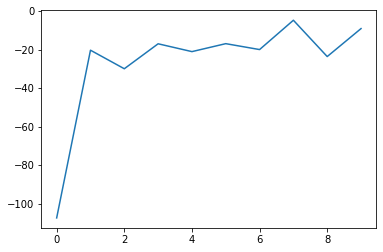

In [9]:
if __name__ == '__main__':
    
    # model hyperparameters
    ALPHA = 0.1
    GAMMA = 1.0
    EPS = 1.0

    Q = {}
    for state in compress.stateSpace:
        for action in compress.action_space :
            Q[state, action] = 0


    numTrials = 10
    totalRewards = np.zeros(numTrials)
    total_played_per_game=[]
    reward = 0
    for i in range(numTrials):        
#         if i % 10 == 0:
        print('Compressing ...  ', i , 'reward ', reward)
        done = False
        epRewards = 0
        observation = compress.reset()
        actions_taken_per_game=0
  
        while not done: 
            w_percentage=(list(compress.current_state).count('1')/compress.number_of_parameters) *100
            if numTrials%5 ==0:
                print("\tw : ",w_percentage,'% Ach acc: ',compress.achived_acc , ' state:', compress.current_state)
            actions_taken_per_game+=1
            rand = np.random.random()
            action = maxAction(Q,observation, compress.action_space) if rand < (1-EPS)  else compress.action_space_sample()

            observation_, reward, done, info = compress.step(action)
            epRewards += reward

            action_ = maxAction(Q, observation_, compress.action_space)
            
            Q[observation,action] = Q[observation,action] + ALPHA*(reward + \
                        GAMMA*Q[observation_,action_] - Q[observation,action])
            observation = observation_
 

        if EPS - 2 / numTrials > 0:
            EPS -= 2 / numTrials
        else:
            EPS = 0

        totalRewards[i] = epRewards
        total_played_per_game.append(actions_taken_per_game)
        actions_taken_per_game=0

    
    plt.plot(totalRewards)
    plt.show()
    

## Small model

In [10]:
small_model = compress.compressed_model
print(small_model[0].state_dict()['weight'])
get_accuracy(tensor_test_x, tensor_test_y,small_model)

tensor([[ 0.5603,  0.7337, -1.0205, -0.7228],
        [ 0.0000,  0.2999,  0.0000,  0.0000]])


0.6

In [11]:
compress.original_weight

tensor([[ 0.5603,  0.7337, -1.0205, -0.7228],
        [-0.4707,  0.2999, -0.1029,  0.2544]])

In [12]:
path

'./iris_model.pt'

In [14]:
torch.save(small_model, 'iris_compressed.pt')

In [15]:
import os
  
sz = os.path.getsize(path)
sz_1=os.path.getsize('./iris_compressed.pt')
  
print(sz, sz_1)

2527 2527


In [1]:
62/70

0.8857142857142857

In [ ]:
path='./iris_model.pt'
dataset = pd.read_csv('./iris.csv')
